# EEG data pre-processing

In [4]:
import pandas as pd
import torch

## Notes:
- Dataset labels are balanced within each participant (3-3), and hence overall.
- Outliers removed at end of this file
- All features are naturally real-valued continuous variables
    - Often naturally positive (before standardisation)
- Data is stored in participant-order, and moreover in first-3-calm, second-3-stress within each participant.

In [5]:
features = pd.read_excel('./data/features_by_participant.xlsx')
print("=== Datatypes ===")
print(features.dtypes) # Excel uses 64-bit precision
# Drop participant number. Participants are in order (6 rows each).
features.drop(features.columns[0], axis=1, inplace=True)
# Convert label from (1=calm, 2=stress) to (0=calm, 1=stress) (sigmoid)
features['label'] = features['label'].map({1: 0, 2: 1})
# List first few rows (for sanity check)
features.head()

=== Datatypes ===
subject_no      int64
mean_AF3      float64
mean_F7       float64
mean_F3       float64
mean_FC5      float64
               ...   
fuzzy_FC6     float64
fuzzy_F4      float64
fuzzy_F8      float64
fuzzy_AF4     float64
label           int64
Length: 212, dtype: object


,mean_AF3,mean_F7,mean_F3,mean_FC5,mean_T7,mean_P7,mean_O1,mean_O2,mean_P8,mean_T8,...,fuzzy_P7,fuzzy_O1,fuzzy_O2,fuzzy_P8,fuzzy_T8,fuzzy_FC6,fuzzy_F4,fuzzy_F8,fuzzy_AF4,label
0,0.004200,0.004551,0.004987,0.004289,0.004429,0.004809,0.004336,0.004537,0.004822,0.004726,...,3.168647,3.281732,3.362600,3.540720,3.518264,3.474538,3.280805,3.550478,3.279160,0
1,0.004199,0.004558,0.004992,0.004300,0.004436,0.004814,0.004340,0.004540,0.004826,0.004723,...,3.269024,3.295630,3.361410,3.509666,3.492213,3.514523,3.282508,3.507425,3.355210,0
2,0.004182,0.004551,0.005003,0.004327,0.004425,0.004804,0.004335,0.004534,0.004822,0.004712,...,3.142487,3.355626,3.460594,3.604878,3.700425,2.583535,3.419328,3.259507,3.532091,0
3,0.004217,0.004577,0.005002,0.004295,0.004435,0.004811,0.004368,0.004541,0.004823,0.004726,...,3.457550,3.491309,3.612129,3.713187,3.783315,3.555657,3.401660,2.955147,3.430246,1
4,0.004178,0.004570,0.005012,0.004328,0.004435,0.004806,0.004337,0.004539,0.004823,0.004726,...,3.703938,3.571311,3.707370,3.845911,3.798872,1.159561,0.967611,2.196881,1.292036,1


In [6]:
# Convert to Pytorch tensor. Keep 64-bit precision while normalising.
Xy = torch.Tensor(features.to_numpy(dtype='float64'))
# Normalize input features
X = Xy[:,:-1]
Xy[:,:-1] = (X - X.mean(axis=0)) / X.std(axis=0)
# Now truncate to 32-bit precision (Pytorch default) (TODO: try bfloat16?)
Xy = Xy.to(dtype=torch.float32)
# Save to file
torch.save(Xy, './data/features_processed_all.pt')
# Sanity check: first 5 rows
print(Xy[:5,:])

tensor([[-0.4080,  0.2138,  0.0378,  ..., -0.0126, -0.3544,  0.0000],
        [-0.4380,  0.2734,  0.0528,  ..., -0.0557, -0.2691,  0.0000],
        [-0.8972,  0.2105,  0.0896,  ..., -0.3035, -0.0709,  0.0000],
        [ 0.0547,  0.4411,  0.0858,  ..., -0.6077, -0.1851,  1.0000],
        [-0.9915,  0.3778,  0.1146,  ..., -1.3657, -2.5812,  1.0000]])


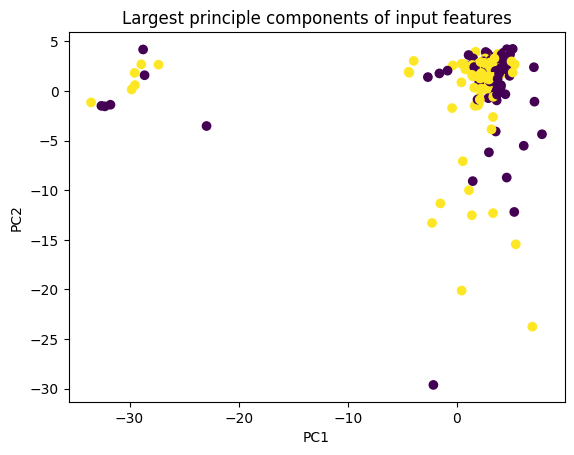

In [7]:
# Perform PCA for zero-centred unit-variance input features
import numpy as np
import matplotlib.pyplot as plt
U, S, V = np.linalg.svd(X)
n_pc = 2 # Number of principal components to display
proj = U[:,:n_pc]*S[:n_pc] # Projected data

# Rough plot of first 2 principal components (colour=calm/stress)
plt.scatter(proj[:,0], proj[:,1], c=Xy[:,-1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Largest principle components of input features")
plt.show()

In [8]:
# Top-left coincidentally has 6 calm and 6 stressed, as if two participants...
# Check which rows are PC1 outliers. Reveals participants 4 and 5 (rows 24-35) (zero-indexed)
outlier_idx = np.where(proj[:,0] < -15)
print(f"Outlier idx: {list(outlier_idx)}")
# How significant are the outliers? Fraction of variance explained:
pc_variances = S**2 / (X.shape[0]-1)
tot_var = np.sum(pc_variances)
pc1_var, pc2_var = pc_variances[:2]
print(f"Total variance: {tot_var}")
print(f"PC1 variance: {pc1_var} ({pc1_var/tot_var:.2%}%)")
print(f"PC2 variance: {pc2_var} ({pc2_var/tot_var:.2%}%)") # For comparison

Outlier idx: [array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])]
Total variance: 209.99998474121094
PC1 variance: 84.93890380859375 (40.45%%)
PC2 variance: 27.74299430847168 (13.21%%)


In [9]:
# Remove outliers and save to file
Xy_no_outliers = torch.cat((Xy[:24,:], Xy[36:,:]))
torch.save(Xy_no_outliers, './data/features_processed_no_outliers.pt')

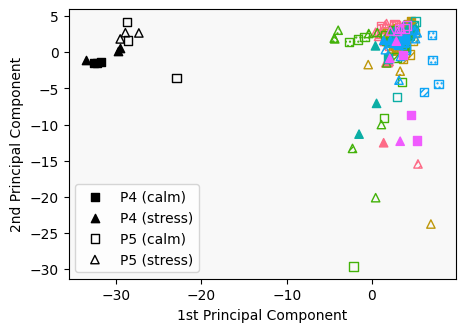

In [10]:
# Create more informative plot for paper
import seaborn as sns
from cycler import cycler

fig, ax = plt.subplots(figsize=(5,3.5))
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
#ax.set_title("Principal components")

# Note data is stored in first-3-calm, last-3-stress order

# Outlier participants in distinctive colour (black)
plt.scatter(proj[24:27,0], proj[24:27,1], marker='s', c='k')
plt.scatter(proj[27:30,0], proj[27:30,1], marker='^', c='k')
plt.scatter(proj[30:33,0], proj[30:33,1], marker='s', facecolors='none', color='k')
plt.scatter(proj[33:36,0], proj[33:36,1], marker='^', facecolors='none', color='k')

# Plot all other participants
# (6 colors, 4 fill styles)
color_cycle = cycler(color=sns.husl_palette(n_colors=6, h=0.01, s=1, l=0.65))
fill_cycle = cycler(hatch=['', '', '/////', '....'], facecolors=[None, 'none', 'none', 'none'])
style_cycle = iter(color_cycle * fill_cycle)

#{'linewidths': 1}
for p in list(range(4))+list(range(6,24)):
  i = p*6 # 6 rows per subject
  style=next(style_cycle)
  # Calm: square
  plt.scatter(proj[i:i+3,0], proj[i:i+3,1], marker='s', **style)
  # Stress: triangle
  plt.scatter(proj[i+3:i+6,0], proj[i+3:i+6,1], marker='^', **style)

# Generate legend for outliers
# https://stackoverflow.com/questions/31478077/how-to-make-two-markers-share-the-same-label-in-the-legend
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html

lgnd_elems = [
  plt.scatter([], [], marker='s', c='k', label='P4 (calm)'),
  plt.scatter([], [], marker='^', c='k', label='P4 (stress)'),
  plt.scatter([], [], marker='s', color='k', label='P5 (calm)', facecolors='none'),
  plt.scatter([], [], marker='^', color='k', label='P5 (stress)', facecolors='none')
]

ax.set_facecolor('#f8f8f8')
ax.legend(handles=lgnd_elems)

#plt.savefig('../draft/pca.pdf', bbox_inches='tight') #pdf is a vector format.

In [11]:
# Check labels for generating feature subsets
print(features.columns)

Index(['mean_AF3', 'mean_F7', 'mean_F3', 'mean_FC5', 'mean_T7', 'mean_P7',
       'mean_O1', 'mean_O2', 'mean_P8', 'mean_T8',
       ...
       'fuzzy_P7', 'fuzzy_O1', 'fuzzy_O2', 'fuzzy_P8', 'fuzzy_T8', 'fuzzy_FC6',
       'fuzzy_F4', 'fuzzy_F8', 'fuzzy_AF4', 'label'],
      dtype='object', length=211)


In [12]:
# Generate feature subsets
import re

get_feat = lambda regex: [l for l in features.columns if re.fullmatch(regex, l)]
# Convert to indices, and add last column (target)
get_idx = lambda names: [features.columns.get_loc(n) for n in names] + [-1]

# Just lobe F7
f7 = get_feat(r".*_F7")
Xy_f7 = Xy_no_outliers[:,get_idx(f7)] 
torch.save(Xy_f7, './data/features_processed_f7.pt')